# This is a visualization tool for test data in Weave, used to help with visualization.

In [1]:
# !pip3 install pandas matplotlib numpy

# Test

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from IPython.display import display, HTML, Image as IPImage
import os
from PIL import Image
import base64
from io import BytesIO
import re

class JSONVisualizerGrouped:
    def __init__(self, json_file_path, images_dir="images"):
        """
        Initialize visualization tool
        """
        self.json_file_path = json_file_path
        self.images_dir = images_dir
        self.data = None
        self.current_group_index = 0
        self.image_display_size = (400, 400)  # Default image display size
        
        # Load data
        self.load_data()
    
    def set_image_size(self, width, height):
        """
        Set the display size for images
        
        Parameters:
        - width (int): Width in pixels for the displayed images
        - height (int): Height in pixels for the displayed images
        
        Returns:
        - self: Returns the instance for method chaining
        """
        self.image_display_size = (width, height)
        print(f"✅ Image display size set to {width}x{height} pixels")
        return self
    
    def load_data(self):
        """
        Load JSON data
        """
        try:
            with open(self.json_file_path, 'r', encoding='utf-8') as f:
                self.data = json.load(f)
            print(f"✅ JSON file successfully loaded: {self.json_file_path}")
            print(f"📊 Total groups found: {len(self.data)}")
                
        except FileNotFoundError:
            print(f"❌ File not found: {self.json_file_path}")
            return False
        except json.JSONDecodeError:
            print(f"❌ JSON format error: {self.json_file_path}")
            return False
        
        # Check images directory
        if not os.path.exists(self.images_dir):
            print(f"⚠️  Images directory not found: {self.images_dir}")
            print("Please ensure the images directory exists, or modify the images_dir parameter")
        else:
            print(f"🖼️  Images directory: {self.images_dir}")
        
        return True
    
    def image_to_base64(self, image_path, max_size=None):
        """
        Convert image to base64 encoding and resize it
        """
        if max_size is None:
            max_size = self.image_display_size
            
        try:
            with Image.open(image_path) as img:
                # Convert to RGB mode if needed
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Resize image
                img.thumbnail(max_size, Image.Resampling.LANCZOS)
                
                # Convert to base64
                buffer = BytesIO()
                img.save(buffer, format='JPEG', quality=85)
                img_str = base64.b64encode(buffer.getvalue()).decode()
                return f"data:image/jpeg;base64,{img_str}"
        except Exception as e:
            print(f"⚠️  Cannot load image {image_path}: {e}")
            return None
    
    def highlight_image_references(self, text):
        """
        Highlight "Image #number" in red and "<image>" in blue bold
        """
        if not isinstance(text, str):
            return text
        
        # Use regex to match "Image #number" pattern (case insensitive)
        pattern_img_num = r'(Image\s*#\s*\d+)'
        highlighted_text = re.sub(
            pattern_img_num, 
            r'<span class="image-reference">\1</span>', 
            text, 
            flags=re.IGNORECASE
        )
        
        # Add highlighting for "<image>" tags in blue bold
        # 使用HTML转义字符确保<image>标签被正确显示为文本
        pattern_img_tag = r'(<image>)'
        highlighted_text = re.sub(
            pattern_img_tag, 
            r'<span class="image-tag">&lt;image&gt;</span>', 
            highlighted_text, 
            flags=re.IGNORECASE
        )
        
        return highlighted_text
    
    def process_dict_key_points(self, key_point_dict):
        if key_point_dict is None:
            return '<span class="null-value">None</span>'
        parts = []
        
        for key, value in key_point_dict.items():
            highlighted_key = self.highlight_image_references(str(key))
            
            if isinstance(value, dict):
                highlighted_value = self.process_dict_key_points(value)
                highlighted_value = re.sub(r'<div[^>]*>(.*?)</div>', r'\1', highlighted_value)
            else:
                highlighted_value = self.highlight_image_references(str(value))
            
            parts.append(f'<b>{highlighted_key}</b>: {highlighted_value}')
        
        result = '<div class="key-point-text">' + ', '.join(parts) + '</div>'
        return result
    
    def show_group(self, group_index=None, show_image_paths=True, show_key_points=True):
        """
        Display data for the specified group
        
        Parameters:
        - group_index (int, optional): Index of the group to display
        - show_image_paths (bool): Whether to display image file paths
        - show_key_points (bool): Whether to display the key points column
        """
        if self.data is None:
            print("❌ Data not loaded successfully")
            return
        
        if group_index is not None:
            if 0 <= group_index < len(self.data):
                self.current_group_index = group_index
            else:
                print(f"❌ Group index out of range. Valid range: 0-{len(self.data)-1}")
                return
        
        current_group = self.data[self.current_group_index]
        
        print(f"\n🔍 Currently displaying: Group {self.current_group_index + 1} / {len(self.data)}")
        print(f"📝 Domain: {current_group.get('domain', 'N/A')}")
        print(f"🖼️  Number of images: {len(current_group.get('images', []))}")
        print(f"💬 Number of messages: {len(current_group.get('chats', []))}")
        
        self.create_detailed_table_with_images(current_group, self.current_group_index + 1, show_image_paths, show_key_points)
    
    def next_group(self):
        """
        Show next group
        """
        if self.current_group_index < len(self.data) - 1:
            self.current_group_index += 1
            self.show_group()
        else:
            print("ℹ️  This is already the last group")
    
    def prev_group(self):
        """
        Show previous group
        """
        if self.current_group_index > 0:
            self.current_group_index -= 1
            self.show_group()
        else:
            print("ℹ️  This is already the first group")
    
    def show_all_groups(self):
        """
        Show overview of all groups
        """
        if self.data is None:
            print("❌ Data not loaded successfully")
            return
        
        print(f"\n📊 Overview of all data groups:")
        
        overview_html = """
        <style>
            .overview-table {
                border-collapse: collapse;
                width: 100%;
                margin: 20px 0;
                font-family: Arial, sans-serif;
            }
            .overview-table th, .overview-table td {
                border: 1px solid #ddd;
                padding: 12px;
                text-align: left;
            }
            .overview-table th {
                background-color: #2196F3;
                color: white;
            }
            .overview-table tr:nth-child(even) {
                background-color: #f2f2f2;
            }
            .current-group {
                background-color: #E8F5E8 !important;
                font-weight: bold;
            }
        </style>
        
        <h3>📋 Data Groups Overview</h3>
        <table class="overview-table">
            <thead>
                <tr>
                    <th>Group #</th>
                    <th>Domain</th>
                    <th>Images</th>
                    <th>Messages</th>
                    <th>User Messages</th>
                    <th>Assistant Replies</th>
                </tr>
            </thead>
            <tbody>
        """
        
        for i, group in enumerate(self.data):
            domain = group.get('domain', 'N/A')
            images_count = len(group.get('images', []))
            chats = group.get('chats', [])
            chats_count = len(chats)
            
            # Count user messages and assistant replies
            user_count = sum(1 for chat in chats if chat.get('role') == 'user')
            assistant_count = sum(1 for chat in chats if chat.get('role') == 'assistant')
            
            row_class = "current-group" if i == self.current_group_index else ""
            
            overview_html += f"""
                <tr class="{row_class}">
                    <td>Group {i+1} {'(Current)' if i == self.current_group_index else ''}</td>
                    <td>{domain}</td>
                    <td>{images_count}</td>
                    <td>{chats_count}</td>
                    <td>{user_count}</td>
                    <td>{assistant_count}</td>
                </tr>
            """
        
        overview_html += """
            </tbody>
        </table>
        """
        
        display(HTML(overview_html))
    
    def plot_domain_distribution(self):
        """
        Calculate domain distribution and plot a donut chart
        """
        if self.data is None:
            print("❌ Data not loaded successfully")
            return
        
        # Count the number for each domain
        domain_counts = {}
        for group in self.data:
            domain = group.get('domain', 'Unknown')
            domain_counts[domain] = domain_counts.get(domain, 0) + 1
        
        # Print statistics
        print("\n" + "="*50)
        print("📊 Domain Distribution")
        print("="*50)
        total = sum(domain_counts.values())
        for domain, count in sorted(domain_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / total) * 100
            print(f"{domain:20s}: {count:3d} groups ({percentage:5.1f}%)")
        print(f"{'Total':20s}: {total:3d} groups")
        print("="*50)
        
        # Plot donut chart
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Prepare data
        domains = list(domain_counts.keys())
        counts = list(domain_counts.values())
        
        # Use a richer color scheme
        colors = plt.cm.Set3(np.linspace(0, 1, len(domains)))
        
        # Draw donut chart
        wedges, texts, autotexts = ax.pie(
            counts,
            labels=domains,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            pctdistance=0.85,
            explode=[0.05] * len(domains),  # Separate each wedge slightly
            textprops={'fontsize': 10, 'weight': 'bold'}
        )
        
        # Create white circle in center to form donut effect
        centre_circle = plt.Circle((0, 0), 0.70, fc='white')
        fig.gca().add_artist(centre_circle)
        
        # Add total count text in center
        ax.text(0, 0, f'Total \n{total} Groups', 
                ha='center', va='center', 
                fontsize=16, weight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        # Beautify percentage text
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontsize(10)
            autotext.set_weight('bold')
        
        # Set title
        plt.title('Domain Distribution', fontsize=16, weight='bold', pad=20)
        
        # Add legend
        ax.legend(
            wedges, 
            [f'{domain}: {count} groups' for domain, count in zip(domains, counts)],
            title="Domain Statistics",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1),
            fontsize=9
        )
        
        plt.tight_layout()
        plt.show()
        
        return domain_counts
    
    def create_detailed_table_with_images(self, group_data, group_number, show_image_paths=True, show_key_points=True):
        """
        Create detailed HTML table with images and conversations
        
        Parameters:
        - group_data (dict): Group data to display
        - group_number (int): Group number for display
        - show_image_paths (bool): Whether to show image file paths
        - show_key_points (bool): Whether to show key points column
        """
        domain = group_data.get('domain', 'N/A')
        images = group_data.get('images', [])
        chats = group_data.get('chats', [])
        
        # Calculate grid size based on image display size
        width, height = self.image_display_size
        grid_cell_width = width + 20  # Add some padding
        
        html_content = f"""
        <style>
            .data-table {{
                border-collapse: collapse;
                width: 100%;
                margin: 20px 0;
                font-family: Arial, sans-serif;
            }}
            .data-table th, .data-table td {{
                border: 1px solid #ddd;
                padding: 12px;
                text-align: left;
                vertical-align: top;
            }}
            .data-table th {{
                background-color: #4CAF50;
                color: white;
                font-weight: bold;
            }}
            .data-table tr:nth-child(even) {{
                background-color: #f2f2f2;
            }}
            .data-table tr:hover {{
                background-color: #f5f5f5;
            }}
            .image-cell {{
                text-align: center;
                width: 150px;
            }}
            .image-preview {{
                max-width: {width}px;
                max-height: {height}px;
                border-radius: 8px;
                box-shadow: 0 2px 4px rgba(0,0,0,0.1);
            }}
            .image-name {{
                font-weight: bold;
                color: #2196F3;
                font-size: 11px;
                margin-top: 5px;
                word-wrap: break-word;
            }}
            .role-user {{
                background-color: #E3F2FD;
                padding: 4px 8px;
                border-radius: 12px;
                font-size: 12px;
                color: #1976D2;
                font-weight: bold;
            }}
            .role-assistant {{
                background-color: #E8F5E9;
                padding: 4px 8px;
                border-radius: 12px;
                font-size: 12px;
                color: #388E3C;
                font-weight: bold;
            }}
            .type-text {{
                background-color: #FFF3E0;
                padding: 2px 6px;
                border-radius: 8px;
                font-size: 11px;
                color: #E65100;
            }}
            .type-image {{
                background-color: #F3E5F5;
                padding: 2px 6px;
                border-radius: 8px;
                font-size: 11px;
                color: #7B1FA2;
            }}
            .content-text {{
                max-width: 300px;
                word-wrap: break-word;
                line-height: 1.5;
            }}
            .null-value {{
                color: #999;
                font-style: italic;
            }}
            .no-image {{
                width: {width // 2}px;
                height: {height // 2}px;
                background-color: #f0f0f0;
                border: 2px dashed #ccc;
                display: flex;
                align-items: center;
                justify-content: center;
                color: #999;
                font-size: 12px;
                border-radius: 8px;
            }}
            .image-reference {{
                color: #FF0000;
                font-weight: bold;
            }}
            .image-tag {{
                color: #0000FF;
                font-weight: bold;
            }}
            .key-point-text {{
                line-height: 1.5;
                word-wrap: break-word;
            }}
            .group-header {{
                background-color: #2196F3;
                color: white;
                padding: 15px;
                margin: 20px 0 10px 0;
                border-radius: 8px;
                text-align: center;
                font-size: 18px;
                font-weight: bold;
            }}
            .images-section {{
                background-color: #E8EAF6;
                padding: 15px;
                margin: 10px 0;
                border-radius: 8px;
            }}
            .images-grid {{
                display: grid;
                grid-template-columns: repeat(auto-fill, minmax({grid_cell_width}px, 1fr));
                gap: 15px;
                margin-top: 10px;
            }}
            .image-item {{
                text-align: center;
            }}
        </style>
        
        <div class="group-header">📋 Domain: {domain.replace('_', ' ').title()}</div>
        
        <div class="images-section">
            <h4>🖼️ Related Images ({len(images)} images)</h4>
            <div class="images-grid">
        """
        
        # Show all related images
        for idx, image_path in enumerate(images, 1):
            # Get full path
            full_image_path = os.path.join(self.images_dir, image_path) if not image_path.startswith(self.images_dir) else image_path
            
            image_html = ""
            if os.path.exists(full_image_path):
                base64_image = self.image_to_base64(full_image_path)
                if base64_image:
                    # Display image with or without path based on show_image_paths
                    if show_image_paths:
                        image_html = f'''
                            <div class="image-item">
                                <img src="{base64_image}" class="image-preview" alt="Image #{idx}">
                                <div class="image-name">Image #{idx}<br>{os.path.basename(image_path)}</div>
                            </div>
                        '''
                    else:
                        image_html = f'''
                            <div class="image-item">
                                <img src="{base64_image}" class="image-preview" alt="Image #{idx}">
                                <div class="image-name">Image #{idx}</div>
                            </div>
                        '''
                else:
                    image_html = f'<div class="image-item"><div class="no-image">Failed to load</div><div class="image-name">Image #{idx}</div></div>'
            else:
                if show_image_paths:
                    image_html = f'<div class="image-item"><div class="no-image">File does not exist</div><div class="image-name">Image #{idx}<br>{os.path.basename(image_path)}</div></div>'
                else:
                    image_html = f'<div class="image-item"><div class="no-image">File does not exist</div><div class="image-name">Image #{idx}</div></div>'
            
            html_content += image_html
        
        html_content += """
            </div>
        </div>
        
        <h4>💬 Conversation</h4>
        <table class="data-table">
            <thead>
                <tr>
                    <th>No.</th>
                    <th>Role</th>
                    <th>Type</th>
                    <th>Content</th>
        """
        
        # Conditionally add Key Points column header
        if show_key_points:
            html_content += "<th>Key Points</th>"
        
        html_content += """
                </tr>
            </thead>
            <tbody>
        """
        
        # Show conversation content
        for i, chat in enumerate(chats, 1):  
            role = chat.get('role', 'N/A')
            chat_type = chat.get('type', 'N/A')
            content = chat.get('content', '')
            key_point = chat.get('key_point')
            
            # Role label
            role_html = f'<span class="role-{role}">{role.upper()}</span>' if role in ['user', 'assistant'] else role
            
            # Type label
            type_html = f'<span class="type-{chat_type}">{chat_type.upper()}</span>' if chat_type in ['text', 'image'] else chat_type
            
            # Content processing - highlight "Image #number"
            if chat_type == 'image':
                content_html = f'<span class="type-image">{content}</span>'
            else:
                # Apply highlighting to text content
                highlighted_content = self.highlight_image_references(content)
                content_html = f'<div class="content-text">{highlighted_content}</div>'
            
            key_point_html = None
            if key_point is None:
                key_point_html = '<span class="null-value">None</span>'
            elif isinstance(key_point, dict):
                key_point_html = self.process_dict_key_points(key_point)
            else:
                key_point_html = self.highlight_image_references(str(key_point))
            
            # Start building the row
            html_content += f"""
                <tr>
                    <td>{i}</td>
                    <td>{role_html}</td>
                    <td>{type_html}</td>
                    <td>{content_html}</td>
            """
            
            # Conditionally add Key Points cell
            if show_key_points:
                html_content += f"<td class=\"content-text\">{key_point_html}</td>"
            
            # Close the row
            html_content += "</tr>"
        
        html_content += """
            </tbody>
        </table>
        """
        
        display(HTML(html_content))


# ==================== Example Usage ====================

json_file_path = "test/test.json"  # NOTE: Please change to actual JSON file path
images_directory = "test"           # NOTE: Images directory path
visualizer = JSONVisualizerGrouped(json_file_path, images_directory)

# Example of using the new features:
# visualizer.set_image_size(600, 500)  # Set images to be 600x500 pixels
# visualizer.show_group(3, show_image_paths=False, show_key_points=False)  # Hide both image paths and key points

✅ JSON file successfully loaded: test/test.json
📊 Total groups found: 100
🖼️  Images directory: test


In [1]:
print("\n" + "="*50)
print("🎯 Usage Instructions:")
print("visualizer.next_group() # View the next group")
print("visualizer.prev_group() # View the previous group")
print("visualizer.show_group(index) # View the specified group")
print("visualizer.show_all_groups() # View an overview of all groups")
print("="*50)


🎯 Usage Instructions:
visualizer.next_group() # View the next group
visualizer.prev_group() # View the previous group
visualizer.show_group(index) # View the specified group
visualizer.show_all_groups() # View an overview of all groups


In [4]:
visualizer.set_image_size(160, 160)

✅ Image display size set to 160x160 pixels



🔍 Currently displaying: Group 33 / 100
📝 Domain: recall
🖼️  Number of images: 6
💬 Number of messages: 10


No.,Role,Type,Content,Key Points
1,USER,TEXT,"Edit the background of Image #1 to feature a bright, geometric abstract mural behind the runway.",None
2,ASSISTANT,IMAGE,Image #2,"GT #1: Edit the background of <image> to feature a bright, geometric abstract mural behind the runway."
3,USER,TEXT,"Make the bold necklace accessory on the model's waist thicker on Image #2 and wrap it around her waist 3 times. Also change the background to the background in Image #1, but with an inverted blue triangle pattern on the top wall.",None
4,ASSISTANT,IMAGE,Image #3,"GT #1: Same as the background in <image>, Image #2: the bold necklace accessory on the model's waist is thicker than <image>"
5,USER,TEXT,Modify Image #3 so the model has her hands on her hips and the accessories on her waist are the same as in Image #2.,None
6,ASSISTANT,IMAGE,Image #4,"Image #2: the accessories on the woman's waist are the same as <image>, Image #3: Modify <image> so the model has her hands on her hips"
7,USER,TEXT,"Change the time of day of the runway in Image #4 to evening, adjusting the lighting accordingly and let the model's right hand hang naturally.",None
8,ASSISTANT,IMAGE,Image #5,"Image #4: Change the time of day of the runway in <image> to evening, adjusting the lighting accordingly and let the model's right hand hang naturally."
9,USER,TEXT,Merge the geometric mural background and the model with her outfit from Image #2 with the evening lighting of Image #5.,None
10,ASSISTANT,IMAGE,Image #6,"Image #2: the geometric mural background and the model with her outfit is same with <image>, Image #5: The evening lighting effect is similar to <image>"

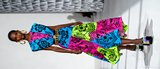
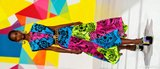
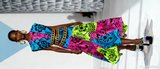
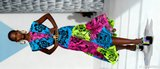
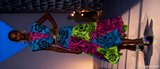
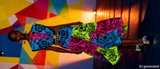

In [ ]:
tune = True
visualizer.show_group(32, show_image_paths=False, show_key_points=True)


📊 Domain Distribution
edit                :  13 groups ( 13.0%)
recall              :  12 groups ( 12.0%)
fusion              :  12 groups ( 12.0%)
story               :  10 groups ( 10.0%)
chemistry           :   7 groups (  7.0%)
geography           :   6 groups (  6.0%)
optics              :   6 groups (  6.0%)
visual_jigsaw       :   5 groups (  5.0%)
spatial             :   5 groups (  5.0%)
physics             :   5 groups (  5.0%)
minecraft           :   5 groups (  5.0%)
chess_game          :   4 groups (  4.0%)
mathematics         :   3 groups (  3.0%)
astronomy           :   3 groups (  3.0%)
maze                :   2 groups (  2.0%)
biology             :   2 groups (  2.0%)
Total               : 100 groups


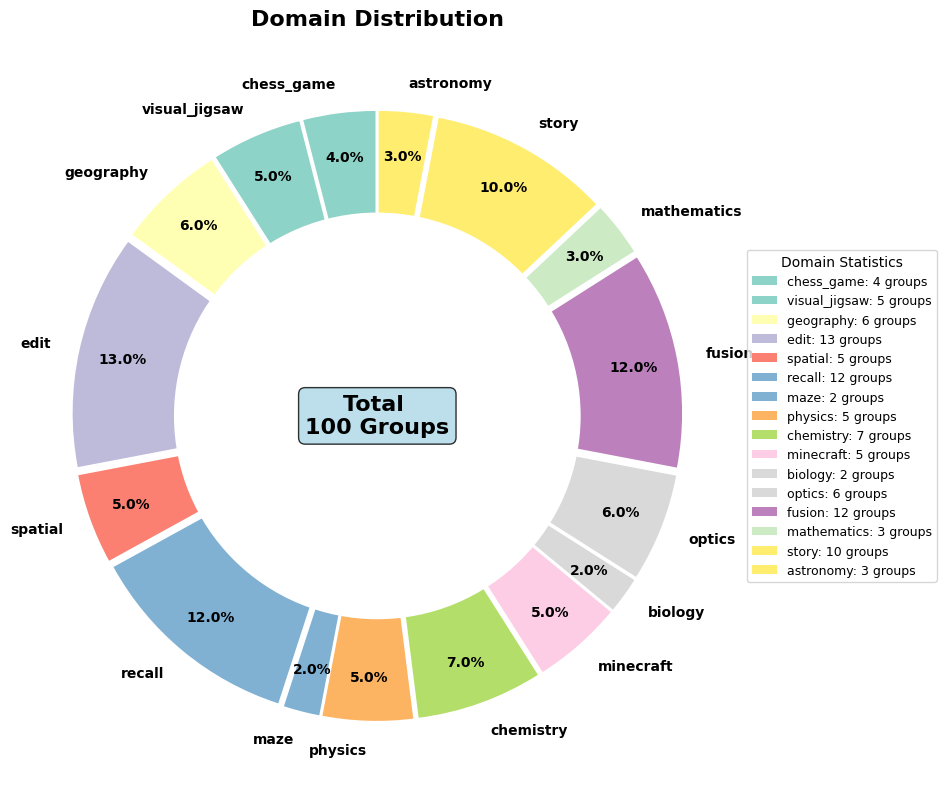

{'chess_game': 4,
 'visual_jigsaw': 5,
 'geography': 6,
 'edit': 13,
 'spatial': 5,
 'recall': 12,
 'maze': 2,
 'physics': 5,
 'chemistry': 7,
 'minecraft': 5,
 'biology': 2,
 'optics': 6,
 'fusion': 12,
 'mathematics': 3,
 'story': 10,
 'astronomy': 3}

In [6]:
visualizer.plot_domain_distribution()